# Correlation and regression

This notebook will demonstrate correlation and regression and explore building energy and water use and climate emissions using data from [Energy and Water Data Disclosure for Local Law 84](https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/usc3-8zwd/about_data) from NYC OpenData

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
energy_water = pd.read_csv( 
   'https://data.cityofnewyork.us/api/views/usc3-8zwd/rows.csv?accessType=DOWNLOAD',
   na_values=['Not Available']
)


/var/folders/g7/v_7ql1m975bc_gyw_57lw50c0000gn/T/ipykernel_3345/2030849019.py:1: DtypeWarning: Columns (9,54,55,194,199,228,229,230) have mixed types. Specify dtype option on import or set low_memory=False.
  energy_water = pd.read_csv(


In [3]:
energy_water.head()

,Property Id,Property Name,Parent Property Id,Parent Property Name,Year Ending,"NYC Borough, Block and Lot (BBL)",NYC Building Identification Number (BIN),Address 1,City,Postcode,...,Number of Active IT Meters,Generation Date,Release Date,Borough,Community Board,Council District,Census Tract,NTA,Longitude,Latitude
0,7365,1155,Not Applicable: Standalone Property,Not Applicable: Standalone Property,12/31/2020,1009970029,1022631,1155 Avenue of the Americas,Manhattan,10036,...,0,05/20/2021 02:43:12 PM,05/20/2021 02:44:16 PM,MANHATTAN,105.0,4.0,119.0,Midtown-Midtown South,-73.982826,40.756631
1,8139,200,Not Applicable: Standalone Property,Not Applicable: Standalone Property,12/31/2020,1013150001,1037545,200 East 42nd St.,Manhattan,10017,...,0,05/20/2021 02:43:12 PM,05/20/2021 02:44:16 PM,MANHATTAN,106.0,4.0,88.0,Turtle Bay-East Midtown,-73.974306,40.750698
2,8604,114,Not Applicable: Standalone Property,Not Applicable: Standalone Property,12/31/2020,1009990019,1022667,114 West 47th st,Manhattan,10036,...,0,05/21/2021 04:10:56 PM,05/21/2021 04:13:00 PM,MANHATTAN,105.0,4.0,125.0,Midtown-Midtown South,-73.982504,40.758310
3,8841,733,Not Applicable: Standalone Property,Not Applicable: Standalone Property,12/31/2020,1013190047,1037596,733 Third Avenue,Manhattan,10017,...,0,05/20/2021 02:43:13 PM,05/20/2021 02:44:16 PM,MANHATTAN,106.0,4.0,90.0,Turtle Bay-East Midtown,-73.972753,40.753074
4,11809,Conde Nast Building,Not Applicable: Standalone Property,Not Applicable: Standalone Property,12/31/2020,1009950005,1085682,4 Times Square,Manhattan,10036,...,0,05/10/2021 06:30:37 PM,05/10/2021 06:34:54 PM,MANHATTAN,105.0,4.0,119.0,Midtown-Midtown South,-73.986244,40.756181


As with all numeric analysis, we first want to inspect the data and filter out outlier values.

Inspect a key column in the data.

<Axes: ylabel='Total GHG Emissions (Metric Tons CO2e)'>

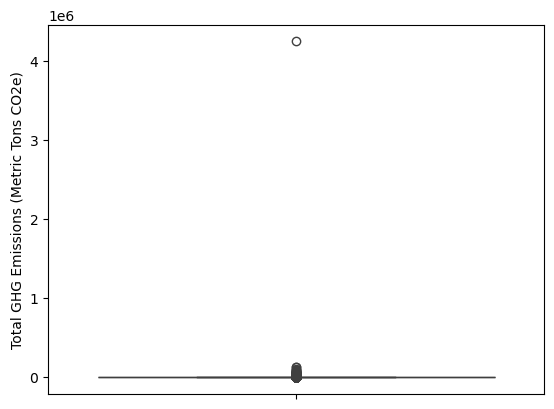

In [4]:
sns.boxplot(energy_water['Total GHG Emissions (Metric Tons CO2e)'])

In [5]:
(
    energy_water
    .loc[[
        energy_water['Total GHG Emissions (Metric Tons CO2e)'].idxmax()
    ]]
    [[
        'Property Name',
        'Total GHG Emissions (Metric Tons CO2e)'
    ]]
)

,Property Name,Total GHG Emissions (Metric Tons CO2e)
19073,Bronx Gardens Rehab and Nursing Center - 2175 ...,4250523.3


This looks like probably a faulty value. Prune it:

In [6]:
energy_water = (
    energy_water
    [
        energy_water['Total GHG Emissions (Metric Tons CO2e)'].lt(4250523)
        &
        energy_water['Total GHG Emissions (Metric Tons CO2e)'].gt(0)
    ]
)

## Correlation

Compute correlation between columns with `.corr()`. This will only work for numeric-type columns. 

We could look at the correlation between _all_ (numeric) columns with: 

In [7]:
(    energy_water
    .select_dtypes('number')
    .corr()
)

,Property Id,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings,Occupancy,ENERGY STAR Score,National Median ENERGY STAR Score,Target ENERGY STAR Score,...,Municipally Supplied Potable Water - Outdoor Use (kgal),Number of Active Energy Meters - Total,Number of Active Energy Meters - Used to Compute Metrics,Number of Active Energy Meters - Not Used to Compute Metrics,Number of Active IT Meters,Community Board,Council District,Census Tract,Longitude,Latitude
Property Id,1.000000,-0.061508,-0.036173,-0.024676,0.073827,0.032799,-0.125044,-0.040869,NaN,0.325283,...,-0.075082,-0.007839,-0.007621,-0.002712,-0.029855,0.054973,0.051595,-0.008735,0.015570,-0.017505
Largest Property Use Type - Gross Floor Area (ft²),-0.061508,1.000000,0.597329,0.562479,0.085969,0.216668,-0.030643,0.033474,NaN,-0.188580,...,-0.179849,0.132451,0.126859,0.059502,0.146542,-0.076406,-0.092446,0.026060,-0.044101,-0.010906
2nd Largest Property Use - Gross Floor Area (ft²),-0.036173,0.597329,1.000000,0.693980,0.048347,0.228728,-0.008264,-0.027529,NaN,-0.149335,...,1.000000,0.125471,0.126419,0.014841,0.062643,-0.050730,-0.048353,0.054300,-0.043361,-0.026872
3rd Largest Property Use Type - Gross Floor Area (ft²),-0.024676,0.562479,0.693980,1.000000,0.060690,0.309347,-0.016131,-0.014436,NaN,-0.173145,...,NaN,0.150022,0.149468,0.019421,0.042417,-0.019646,-0.009265,0.032234,-0.057614,-0.051809
Year Built,0.073827,0.085969,0.048347,0.060690,1.000000,0.000412,-0.040273,0.022607,NaN,-0.081355,...,0.082020,-0.044352,-0.051552,0.045126,0.022696,0.181638,0.132233,0.041780,0.076660,-0.111935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Community Board,0.054973,-0.076406,-0.050730,-0.019646,0.181638,0.066740,0.022236,-0.007285,NaN,0.013075,...,-0.171976,-0.007061,-0.003175,-0.027774,-0.032517,1.000000,0.812800,0.242086,0.339511,-0.503276
Council District,0.051595,-0.092446,-0.048353,-0.009265,0.132233,0.026378,0.028812,-0.008004,NaN,0.007077,...,-0.146274,-0.055061,-0.051309,-0.034014,-0.034141,0.812800,1.000000,0.138383,0.023855,-0.708600
Census Tract,-0.008735,0.026060,0.054300,0.032234,0.041780,0.108529,0.025847,-0.016308,NaN,0.009778,...,-0.096072,0.118137,0.118586,0.014550,-0.001977,0.242086,0.138383,1.000000,0.327244,-0.075876
Longitude,0.015570,-0.044101,-0.043361,-0.057614,0.076660,0.079429,0.042593,-0.067926,NaN,0.007916,...,-0.094767,0.092924,0.095749,-0.005556,-0.035558,0.339511,0.023855,0.327244,1.000000,0.330502


But these data have a _lot_ of columns so first pick a few to look at:

In [8]:
focus_cols = [
    
    'Property GFA - Self-Reported (ft²)',
    'Property GFA - Calculated (Buildings and Parking) (ft²)',
    'Property GFA - Calculated (Buildings) (ft²)',
    'Year Built',
    'Occupancy',

    'Total GHG Emissions (Metric Tons CO2e)',
    'Direct GHG Emissions (Metric Tons CO2e)',
    'Total GHG Emissions Intensity (kgCO2e/ft²)',
    'Direct GHG Emissions Intensity (kgCO2e/ft²)',

    'ENERGY STAR Score',
    'Site Energy Use (kBtu)',
    'Weather Normalized Site Energy Use (kBtu)',
    'Weather Normalized Site Electricity Intensity (kWh/ft²)',
    'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
    'Fuel Oil #1 Use (kBtu)',
    'Fuel Oil #2 Use (kBtu)',
    'Fuel Oil #4 Use (kBtu)',
    'Fuel Oil #5 & 6 Use (kBtu)',
    'Diesel #2 Use (kBtu)',
    'Propane Use (kBtu)',
    'Weather Normalized Site Natural Gas Use (therms)',
    'Electricity Use - Grid Purchase (kWh)',
    'Weather Normalized Site Electricity (kWh)',
 
]

add a `style.background_gradient()` to make a colored heatmap (to make it easy to pick out the highest and lowest values)

In [10]:
(
    energy_water
    [focus_cols]
    .corr()
    .dropna(how='all')
    .dropna(axis=1,how='all')
    .style
    .background_gradient(
        cmap='RdBu',
        vmin=-1, # Set min and max of the colormap to -1 and 1
        vmax=1
    )
)

,Property GFA - Self-Reported (ft²),Property GFA - Calculated (Buildings and Parking) (ft²),Property GFA - Calculated (Buildings) (ft²),Year Built,Occupancy,Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Total GHG Emissions Intensity (kgCO2e/ft²),Direct GHG Emissions Intensity (kgCO2e/ft²),ENERGY STAR Score,Site Energy Use (kBtu),Weather Normalized Site Energy Use (kBtu),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kWh),Weather Normalized Site Electricity (kWh)
Property GFA - Self-Reported (ft²),1.000000,0.995747,0.999568,0.083696,-0.030080,0.739701,0.607306,0.021157,-0.020640,0.030672,0.724234,0.725123,0.057060,-0.004193,-0.344488,0.267484,0.253740,0.152597,0.719020,0.626440,0.614115,0.592923
Property GFA - Calculated (Buildings and Parking) (ft²),0.995747,1.000000,0.996094,0.086581,-0.029216,0.744473,0.619484,0.022025,-0.019062,0.028421,0.730600,0.731069,0.058243,-0.002554,-0.341076,0.270063,0.249939,0.156820,0.704972,0.637839,0.613436,0.592898
Property GFA - Calculated (Buildings) (ft²),0.999568,0.996094,1.000000,0.083404,-0.030368,0.739328,0.606715,0.020626,-0.020860,0.031338,0.723737,0.725264,0.056042,-0.004320,-0.339547,0.268106,0.253653,0.152597,0.719028,0.626528,0.614105,0.592860
Year Built,0.083696,0.086581,0.083404,1.000000,-0.040273,0.051678,0.021467,-0.021016,-0.075754,0.022607,0.046684,0.049346,0.108507,-0.014382,-0.220181,0.026128,0.163034,0.306217,-0.093171,0.035360,0.087293,0.091021
Occupancy,-0.030080,-0.029216,-0.030368,-0.040273,1.000000,0.005029,0.019968,0.047391,0.064158,-0.082338,0.008236,0.008198,-0.010420,0.042124,nan,0.012793,0.098833,-0.147143,0.027284,0.014177,-0.017071,-0.016928
Total GHG Emissions (Metric Tons CO2e),0.739701,0.744473,0.739328,0.051678,0.005029,1.000000,0.868100,0.399012,0.301737,-0.080953,0.991639,0.991145,0.264131,0.317486,-0.280322,0.259369,0.153496,0.150256,0.794029,0.885211,0.771618,0.772728
Direct GHG Emissions (Metric Tons CO2e),0.607306,0.619484,0.606715,0.021467,0.019968,0.868100,1.000000,0.352773,0.377076,-0.075701,0.913497,0.910566,0.139484,0.371645,0.029071,0.254297,0.238660,0.219536,0.800261,0.994971,0.418440,0.430737
Total GHG Emissions Intensity (kgCO2e/ft²),0.021157,0.022025,0.020626,-0.021016,0.047391,0.399012,0.352773,1.000000,0.873091,-0.530855,0.398232,0.397516,0.608466,0.874760,0.289686,0.178202,0.158831,0.148880,0.480905,0.366146,0.271706,0.277314
Direct GHG Emissions Intensity (kgCO2e/ft²),-0.020640,-0.019062,-0.020860,-0.075754,0.064158,0.301737,0.377076,0.873091,1.000000,-0.507564,0.323196,0.312934,0.178245,0.936785,0.830914,0.199440,0.229835,0.341680,0.511261,0.369522,0.098579,0.101791
ENERGY STAR Score,0.030672,0.028421,0.031338,0.022607,-0.082338,-0.080953,-0.075701,-0.530855,-0.507564,1.000000,-0.082336,-0.080382,-0.268477,-0.453481,-0.361189,-0.103782,-0.050146,-0.308685,-0.122664,-0.072496,-0.036920,-0.036685


Exploration of correlation coefficients suggests related variables.

## Scatter plots

Scatter plots illustrate the shape and strength of relationships between variables (and help spot other outliers)

Model the relationship between the size of buildings and their total emissions.

In [11]:
x_col = 'Property GFA - Calculated (Buildings) (ft²)'
y_col = 'Total GHG Emissions (Metric Tons CO2e)'

<Axes: xlabel='Property GFA - Calculated (Buildings) (ft²)', ylabel='Total GHG Emissions (Metric Tons CO2e)'>

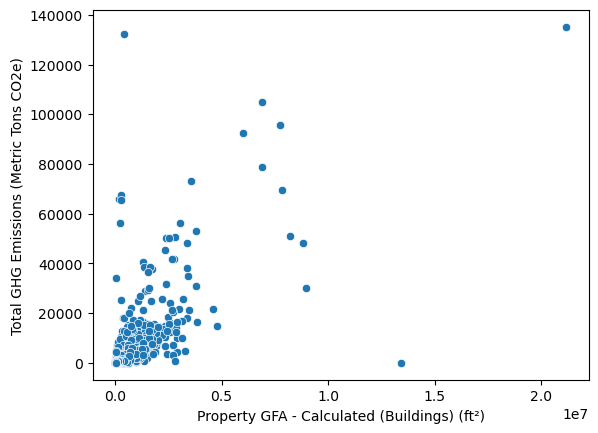

In [12]:
sns.scatterplot(
    data=energy_water,
    x=x_col,
    y=y_col
)

Prune some more of those outlier values (to better observe the relationship of buildings with more typical values)

In [13]:
subset = (
    energy_water
    [
        energy_water[x_col].lt(energy_water[x_col].quantile(0.99))
        &
        energy_water[x_col].gt(0)
        &
        energy_water[y_col].lt(energy_water[y_col].quantile(0.99))
        &
        energy_water[y_col].gt(0)
    ]
)

<Axes: xlabel='Property GFA - Calculated (Buildings) (ft²)', ylabel='Total GHG Emissions (Metric Tons CO2e)'>

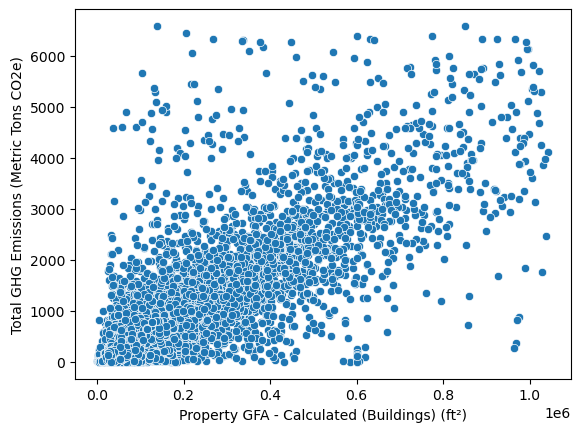

In [14]:
sns.scatterplot(
    data=subset,
    x=x_col,
    y=y_col
)

Add a fit line with `regplot`

<Axes: xlabel='Property GFA - Calculated (Buildings) (ft²)', ylabel='Total GHG Emissions (Metric Tons CO2e)'>

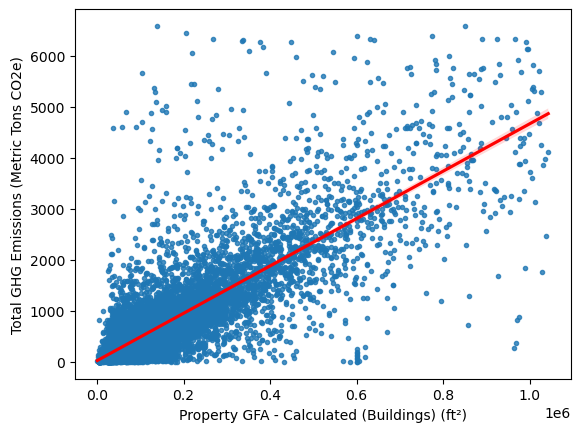

In [18]:
sns.regplot(
    data=subset,
    x=x_col,
    y=y_col,
    marker='.',
    line_kws=dict(color='red')
)


## Regression

Model the relationship between the size of buildings and their total emissions.

For modeling the typical relationship between typical examples, it makes sense to remove some outliers that would skew the model:

In [ ]:
# x_col = 'Property GFA - Calculated (Buildings) (ft²)'
# y_col = 'Total GHG Emissions (Metric Tons CO2e)'

# subset = (
#     energy_water
#     [
#         energy_water[x_col].lt(energy_water[x_col].quantile(0.99))
#         &
#         energy_water[x_col].gt(0)
#         &
#         energy_water[y_col].lt(energy_water[y_col].quantile(0.99))
#         &
#         energy_water[y_col].gt(0)
#     ]
# )

Fit the regression model:

(For column names with spaces, use `Q(" ")` surrounding the column names)

In [73]:
formula = 'Q("Total GHG Emissions (Metric Tons CO2e)") ~ Q("Property GFA - Calculated (Buildings) (ft²)")'

In [74]:
model = smf.ols(data=subset, formula=formula)

fit_model = model.fit()

fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     Q("Total GHG Emissions (Metric Tons CO2e)")   R-squared:                       0.693
Model:                                                     OLS   Adj. R-squared:                  0.693
Method:                                          Least Squares   F-statistic:                 5.975e+04
Date:                                         Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                                                 17:27:15   Log-Likelihood:            -1.8699e+05
No. Observations:                                        26499   AIC:                         3.740e+05
Df Residuals:                                            26497   BIC:                         3.740e+05
Df Model:                                                    1                                         
Covariance Type:                                     nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           41.5910      2.402     17.315      0.000      36.883      46.299
Q("Property GFA - Calculated (Buildings) (ft²)")     0.0043   1.78e-05    244.442      0.000       0.004       0.004
==============================================================================
Omnibus:                    12060.802   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           510869.635
Skew:                           1.485   Prob(JB):                         0.00
Kurtosis:                      24.304   Cond. No.                     1.88e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.88e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

(It may be easier to write formulas with column names that don't have spaces. This works too:)

In [21]:
subset_rename = (
    subset
    .rename(columns={
        'Total GHG Emissions (Metric Tons CO2e)':'total_emissions',
        'Property GFA - Calculated (Buildings) (ft²)':'floor_area'
    })
)

formula = 'total_emissions ~ floor_area'

model = smf.ols(data=subset_rename, formula=formula)

fit_model = model.fit()

fit_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        total_emissions   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                 6.047e+04
Date:                Wed, 09 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:19:52   Log-Likelihood:            -1.9604e+05
No. Observations:               26789   AIC:                         3.921e+05
Df Residuals:                   26787   BIC:                         3.921e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.1597      2.929      8.590      0.000      19.419      30.900
floor_area     0.0046   1.89e-05    245.916      0.000       0.005       0.005
==============================================================================
Omnibus:                    22578.772   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2503052.778
Skew:                           3.483   Prob(JB):                         0.00
Kurtosis:                      49.840   Cond. No.                     2.04e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Tasks

1. Model "Electricity Use - Grid Purchase (kWh)" as a function of building size ("Property GFA - Calculated (Buildings) (ft²)")
   1. Filter these variables as appropriate before modeling.
   2. Plot a scatter plot.
   3. Fit a regression model.
   4. How many additional grid-purchased kWh are associated with each additional square foot of building size? 
   5. Can you reject the null hypothesis and say this coefficient statistically significantly different from zero? 
   6. Is building size a better predictor of electricity use or of total GHG emissions? 


2. Choose another pair of variables that show strong correlation. Plot a scatter plot. If you identify a linear relationship, fit a linear model. Interpret the result.